In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv("latest_binance_data.csv")
print(data.head(0))
data = data.loc[:,['date','high','low','open','volume','close']]
print(data.head(5))
print(data.date)

Empty DataFrame
Columns: [unix, date, symbol, open, high, low, close, volume]
Index: []
         date      high       low      open       volume     close
0  05-27-2024  69298.00  68481.31  68507.67   3780.90727  68692.96
1  05-26-2024  69562.23  68128.01  69290.56  11872.11797  68507.67
2  05-25-2024  69610.00  68500.00  68549.99  12130.39418  69290.57
3  05-24-2024  69250.00  66600.12  67969.66  28095.83664  68549.99
4  05-23-2024  70096.12  66312.16  69166.62  40513.17374  67969.65
0      05-27-2024
1      05-26-2024
2      05-25-2024
3      05-24-2024
4      05-23-2024
          ...    
995    09-05-2021
996    09-04-2021
997    09-03-2021
998    09-02-2021
999    09-01-2021
Name: date, Length: 1000, dtype: object


In [3]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2024-05-27', '2024-05-26', '2024-05-25', '2024-05-24',
               '2024-05-23', '2024-05-22', '2024-05-21', '2024-05-20',
               '2024-05-19', '2024-05-18',
               ...
               '2021-09-10', '2021-09-09', '2021-09-08', '2021-09-07',
               '2021-09-06', '2021-09-05', '2021-09-04', '2021-09-03',
               '2021-09-02', '2021-09-01'],
              dtype='datetime64[ns]', name='date', length=1000, freq=None)


In [4]:
aim = 'close'

In [5]:
train_data = data.iloc[200:]
test_data = data.iloc[:200]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Bitcoin/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

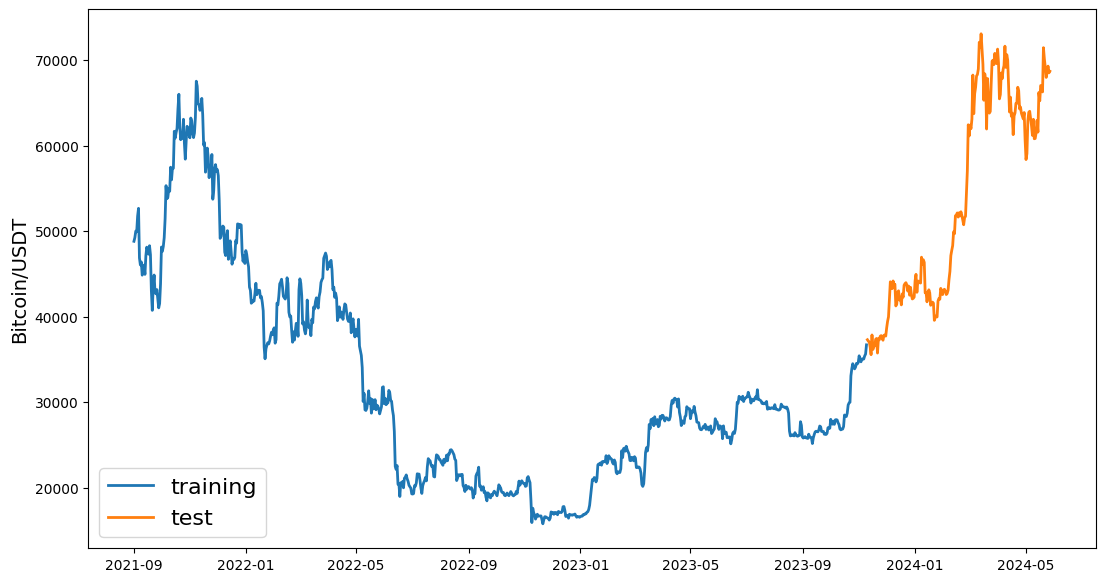

In [6]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [7]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [8]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test
import numpy as np

In [9]:
from tensorflow.keras import layers

In [10]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [11]:
print(X_train.shape)

(795, 5, 5)


In [12]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

d:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 7.9671e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 9.2197e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 7.1310e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 6.4226e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 6.1948e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 6.6564e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 6.1015e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 5.5847e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 5.2864e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7045e-04 - val_loss: 5.4101e-04
Epoch 12/20
25/25 ━━━━━━━━━━━

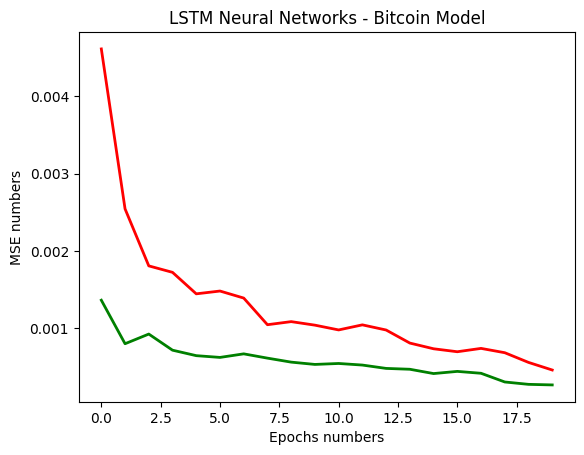

In [13]:
import matplotlib.pyplot as plt
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - Bitcoin Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [14]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


0.01320682087910112

In [15]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.00029400268159302336

In [16]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

91.14998012329885

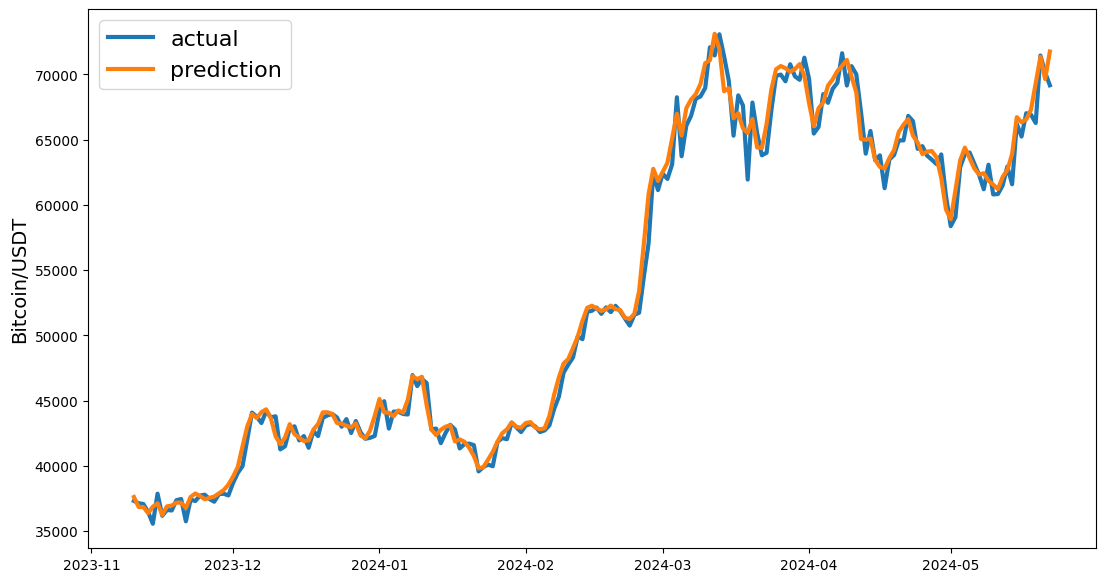

In [17]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)